<a href="https://colab.research.google.com/github/astro-blue/Data-analysis-in-astronomy-2023/blob/main/week_13/Neural_network_Galaxy_images_in_class_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"

Mounted at /content/gdrive


In [2]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt

### You can find the data at https://drive.google.com/file/d/1hpDKSielsWGzuSwKI2M-mNzctK-2LF_w/view?usp=sharing

In [3]:
data = pf.open(root_dir+'Combined_DES_images_catalog.fits')
'''
Imaging dataset provided by Ting-Yun Cheng
DES image dataset
'''

image = np.copy(data[0].data)
for i in range(0,len(image)):
    small = image[i]
    search = np.where(small<=0)
    search_2 = np.where(small>0)
    small[search] = np.min(small[search_2])
    image[i]=small

flat_image = np.log10(image.reshape(2862,2500))
origin_image = image.reshape(2862,2500)
#flat_image = image.reshape(2862,2500)
labels = data[1].data['spiral']

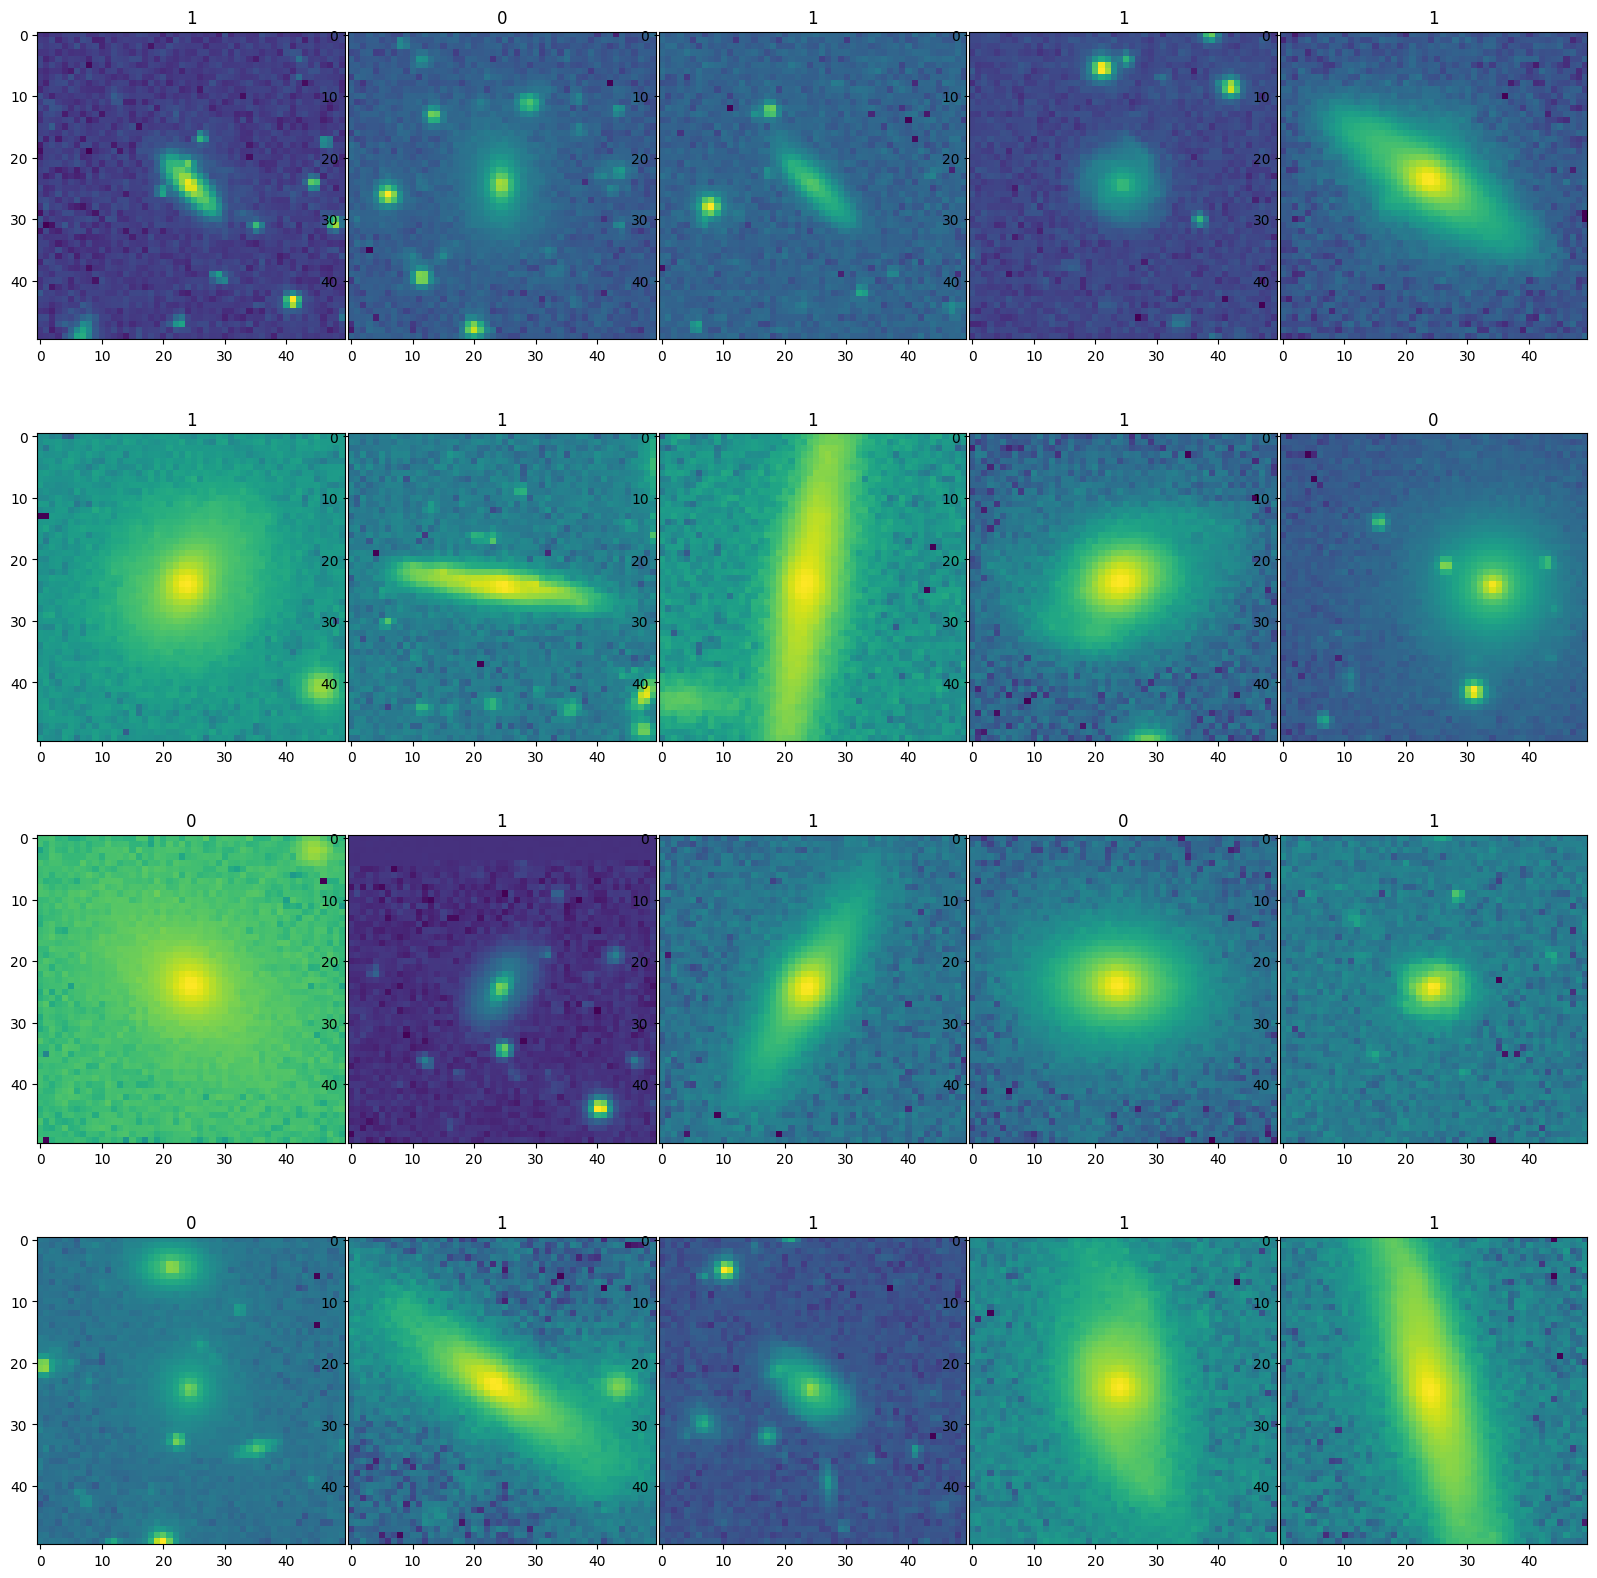

In [4]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.01)
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(flat_image[i].reshape(50,50))
    plt.title(labels[i])

In [128]:
import torch
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class fully_connected_NN(torch.nn.Module):
    def __init__(self):
        super(fully_connected_NN, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(2500, 5000),
            #torch.nn.BatchNorm1d(5000),
            torch.nn.ReLU())

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(5000, 2),
            )
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = x
        return out

cuda


In [129]:
'''This block is to organize data into Pytorch form'''

image_all = torch.from_numpy(np.array(origin_image,dtype=np.float32))
image_labels_all = np.zeros((len(labels),2))
for i in range(0,len(image_labels_all)):
    image_labels_all[i,labels[i]]=1

image_labels_all = torch.from_numpy(image_labels_all)

'''Using 0-2300 as the training set'''
image_train = image_all[0:2300].to(device)
image_labels = image_labels_all[0:2300,:].to(device)

'''Using 2300-2862 as the test set'''
test_labels = image_labels_all[2300:].to(device)
image_test = image_all[2300:,:].to(device)

In [135]:
model = fully_connected_NN().to(device)

In [136]:
learningRate = 0.01
epochs = 500
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropy()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [137]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []
batch_size = 64
N_total_train = len(image_labels)
for epoch in range(epochs):
    model.train()
    for start_index_batch in range(0,N_total_train,batch_size):
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        end_index = min(start_index_batch + batch_size, N_total_train)
        # get output from the model, given the inputs
        outputs = model(image_train[start_index_batch:end_index,:])

        # get loss for the predicted output
        loss = criterion(outputs, image_labels[start_index_batch:end_index,:])
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()


    model.eval()
    with torch.no_grad():
        outputs_all = model(image_train)
        loss_all = criterion(outputs_all, image_labels)
        #print(float(loss_kk.cpu().detach().numpy()))
        pred_y = torch.max(outputs_all, 1)[1].cpu().data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].cpu().data.squeeze()) / pred_y.size(0))
        #print(accuracy)
        #if epoch % 50 ==0:
        #    print(epoch,accuracy,loss_all)

        epoch_array.append(epoch)
        loss_array.append(float(loss_all.cpu().detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test)
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].cpu().data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].cpu().data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.cpu().detach().numpy()))

    if epoch % 50 ==0:
        print(epoch,accuracy.numpy(),loss.cpu().detach().numpy(), accuracy_test.numpy(),loss_test.cpu().detach().numpy())


0 0.7373914 0.577364057302475 0.72419924 0.5813274801944074
50 0.7373914 0.5117497955759366 0.72419924 0.5177835387067357
100 0.7456523 0.49634648483867444 0.7313167 0.4894650169679353
150 0.77217406 0.473683546607693 0.77757996 0.46550949346106996
200 0.79826105 0.44390940787270666 0.80071163 0.44517096704508435
250 0.814348 0.41060232190648094 0.79537356 0.4270686493764636
300 0.83652186 0.37596486663290607 0.8007117 0.41053964166437784
350 0.8591306 0.3419815031887993 0.8131672 0.39606168493751653
400 0.87695664 0.30938529710177437 0.82384336 0.38389891531997883
450 0.9004349 0.279301277289854 0.827402 0.3745892731483736


(0.7, 1.0)

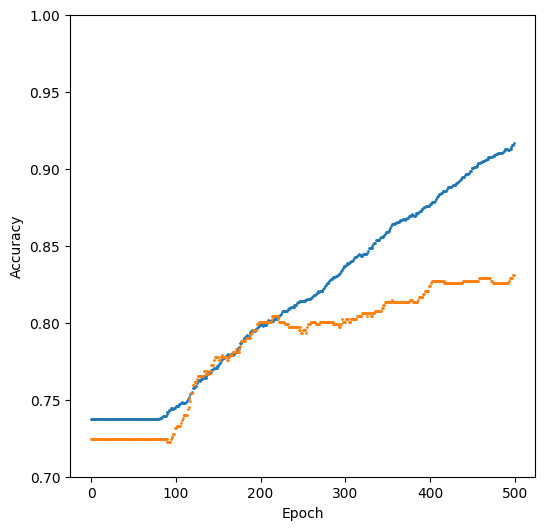

In [138]:
plt.figure(figsize=(6,6))
plt.scatter(epoch_array,accuracy_array,s=1)
plt.scatter(epoch_array,accuracy_test_array,s=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)

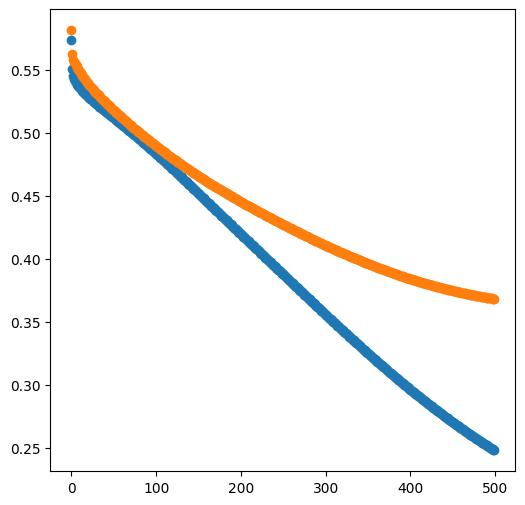

In [139]:
plt.figure(figsize=(6,6))
plt.scatter(epoch_array,loss_array)
plt.scatter(epoch_array,loss_test_array)

### Exercise one: Try to build a better model to obtain a better accuracy

Note that I encountered some problems which are not fully resolved.
https://discuss.pytorch.org/t/performance-highly-degraded-when-eval-is-activated-in-the-test-phase/3323/65